## Set Dependencies

In [1]:
pip install PyPortfolioOpt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import inv
from pypfopt import EfficientFrontier as efk

/Users/nasruddinislambinramli/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
!pip install --upgrade openpyxl

In [4]:
df = pd.read_excel("Industry_Portfolios.xlsx")

/Users/nasruddinislambinramli/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Clean Date col and set index

In [5]:
df["Date"] =\
    df\
    .Date\
    .apply(lambda x: str(x))

df["Date"] =\
    pd\
    .to_datetime(df.Date,
                 format="%Y%m")

df =\
    df\
    .set_index("Date")

In [6]:
mean_rt =\
    df.T.mean(axis=1)

std_dev =\
    df.T.std(axis =1)

In [7]:
mean_sd =\
    pd\
    .DataFrame({"mean_returns": mean_rt,
                "std_dev": std_dev})
    
mean_sd

,mean_returns,std_dev
NoDur,0.902833,3.345657
Durbl,0.733333,8.361852
Manuf,1.012833,5.310270
Enrgy,1.231167,6.081524
HiTec,0.766250,5.381191
Telcm,0.881417,4.448284
Shops,0.916333,4.093786
Hlth,0.783833,3.787172
Utils,0.907167,3.701763
Other,0.489083,5.582452


In [8]:
Returns = mean_sd.mean_returns

R =\
    Returns # nx1

V =\
    df\
    .cov()

V_matrix =\
    np\
    .asmatrix(V)

V_inv =\
    inv(V_matrix)

e =\
    np\
    .ones(
        (V_matrix.shape[0],1))

In [9]:
alpha =\
    float(R.T @ V_inv @ e)

print(alpha)

0.13794323869931885


In [10]:
gamma =\
    float(R.T @ V_inv @ R)

print(gamma)

0.19640858464482272


In [11]:
delta =\
    float(e.T @ V_inv @ e)

print(delta)

0.1373875973567116


In [12]:
R_mv =\
    alpha/delta

R_mv

1.004044334083262

In [13]:
R_p =\
    np\
    .arange(0, 2.1, 0.1)

R_p

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [14]:
sigma =\
    np\
    .sqrt((1/delta)\
          + (delta/(gamma*delta-alpha**(2)))\
          * (R_p - R_mv)**(2))

sigma

array([4.96865933, 4.62520378, 4.29451081, 3.97976317, 3.68504889,
       3.41555771, 3.17771336, 2.97910534, 2.82801233, 2.73232821,
       2.69795476, 2.7272112 , 2.81811651, 2.96500574, 3.16008166,
       3.39504812, 3.66223513, 3.9551181 , 4.26841081, 4.59794314,
       4.94046659])

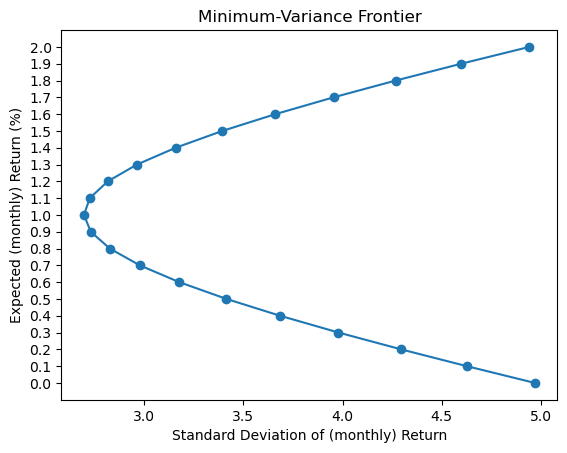

In [15]:
plt\
    .plot(sigma, R_p, marker = 'o')

plt\
    .title("Minimum-Variance Frontier")

plt\
    .xlabel("Standard Deviation of (monthly) Return")

plt\
    .yticks(np.arange(0, 2.1, 0.1))

plt\
    .ylabel("Expected (monthly) Return (%)")

plt\
    .show()

In [26]:
rf_rt = 0.13

R_p_rf =\
    np\
    .linspace(0,
              2,
              100)

In [27]:
def rf_sd(alpha, gamma, delta, R_p_rf, rf_rt):
    
    sigma_p_riskless =\
        (R_p_rf - rf_rt)/np.sqrt(gamma - 2*alpha*rf_rt + delta*(rf_rt**2))

    return sigma_p_riskless

In [28]:
sd_rf =\
    rf_sd(alpha,
           gamma,
           delta,
           R_p_rf,
           rf_rt)

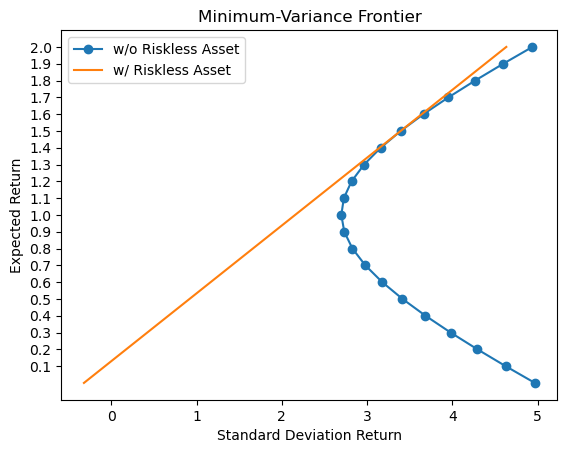

In [29]:
plt\
    .plot(sigma,
          R_p,
          label="w/o Riskless Asset", marker = 'o')

plt\
    .title("Minimum-Variance Frontier")

plt\
    .xlabel("Standard Deviation Return")

plt\
    .yticks(np\
            .arange(0.1,
                    2.1,
                    0.1))

plt\
    .ylabel("Expected Return")

plt\
    .plot(sd_rf,
          R_p_rf,
          label="w/ Riskless Asset")

plt\
    .legend()

plt\
    .show()

In [30]:
def tangency_sharpe_ratio(alpha, gamma, delta, rf_rate):
    
    tg_sharpe_ratio =\
        np\
        .sqrt(gamma\
              - 2*alpha*rf_rt\
              + delta*rf_rt**2)

    return tg_sharpe_ratio

In [31]:
def get_tangency_portfolio_weights(alpha, gamma, delta, V, mean_rt, rf_rt):

    V_inv =\
        inv(V)
    
    e =\
        np\
        .ones((V_inv.shape[0],
               1))
    
    R_tg =\
        (alpha*rf_rt - gamma)/(delta*rf_rt - alpha)
    
    a =\
        np\
        .array((gamma*V_inv.dot(e)-alpha*V_inv.dot(mean_rt))/(gamma*delta-alpha**2)).T
    
    b =\
        np\
        .array((delta*V_inv.dot(mean_rt) - alpha*V_inv.dot(e))/(gamma*delta-alpha**2)).T
    
    weight =\
        np\
        .diagonal(a + b*R_tg)

    return weight

In [32]:
tangency_pf_sharpe_ratio =\
    tangency_sharpe_ratio(alpha, 
                          gamma,
                          delta,
                          rf_rt)

tangency_pf_sharpe_ratio

0.4035655993495088

In [33]:
tangency_weights =\
    get_tangency_portfolio_weights(alpha,
                                   gamma,
                                   delta,
                                   V,
                                   mean_rt,
                                   rf_rt)
tangency_weights

array([ 0.56797218, -0.2140726 ,  0.71410511,  0.10408719, -0.36343817,
       -0.09546326,  0.99164683,  0.0755702 ,  0.13264333, -0.91305081])

In [34]:
mean_sd['tangent weights'] =\
    tangency_weights

In [25]:
mean_sd['tangent weights']

NoDur    0.567972
Durbl   -0.214073
Manuf    0.714105
Enrgy    0.104087
HiTec   -0.363438
Telcm   -0.095463
Shops    0.991647
Hlth     0.075570
Utils    0.132643
Other   -0.913051
Name: tangent weights, dtype: float64